# 1.Import libraries and objects

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import sklearn as sk
from matplotlib.backends.backend_pdf import PdfPages
import re
import seaborn as sns
from matplotlib import pyplot
%matplotlib inline
import time
import math
from math import sqrt
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Functions

## 2.1 Load data

In [2]:
def load(handel,old_handel):
    dfe=pd.read_csv(handel,index_col=None)
    df1=pd.read_csv(r"peridic.csv",index_col=None)
    dfe= dfe.loc[:, ~dfe.columns.str.contains('^Unnamed')]
    nul=[np.NaN]*len(dfe.Molecule)
    for char in ['e1','e2']:
        dfe[char]=nul
    for char in df1.Symbol:
        ind1=dfe.loc[dfe['Molecule'].str.contains(r'^'+char+r'\D')].index.values
        ind2=dfe.loc[dfe['Molecule'].str.contains(char+r'$')].index.values
        ind3=dfe.loc[dfe['Molecule'].str.contains(r'^'+char+r'2')].index.values
        dfe.loc[ind1,'e1']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind2,'e2']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind3,'e1']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind3,'e2']=df1[df1.Symbol==char].NumberofElectrons.values[0]
    g=dfe
    g['n1']=g.A1-g.e1
    g['n2']=g.A2-g.e2
    g.loc[g.atom2=='H','p2']=[1]*len(g.loc[g.atom2=='H']['p2'])
    g.loc[g.atom1=='H','p1']=[1]*len(g.loc[g.atom1=='H']['p1'])
    g.loc[g.atom2=='H','g2_lan_act']=[1]*len(g.loc[g.atom2=='H']['g2_lan_act'])
    g.loc[g.atom1=='H','g1_lan_act']=[1]*len(g.loc[g.atom1=='H']['g1_lan_act'])
    
    
    
    g.loc[g.atom2=='D','p2']=[1]*len(g.loc[g.atom2=='D']['p2'])
    g.loc[g.atom1=='D','p1']=[1]*len(g.loc[g.atom1=='D']['p1'])
    g.loc[g.atom2=='T','p2']=[1]*len(g.loc[g.atom2=='T']['p2'])
    g.loc[g.atom1=='T','p1']=[1]*len(g.loc[g.atom1=='T']['p1'])
    g.loc[g.atom2=='D','g2']=[1]*len(g.loc[g.atom2=='D']['g2'])
    g.loc[g.atom1=='D','g1']=[1]*len(g.loc[g.atom1=='D']['g1'])
    g.loc[g.atom2=='T','g2']=[1]*len(g.loc[g.atom2=='T']['g2'])
    g.loc[g.atom1=='T','g1']=[1]*len(g.loc[g.atom1=='T']['g1'])
    g.loc[g.atom2=='D','g2_lan_act']=[1]*len(g.loc[g.atom2=='D']['g2_lan_act'])
    g.loc[g.atom1=='D','g1_lan_act']=[1]*len(g.loc[g.atom1=='D']['g1_lan_act'])
    g.loc[g.atom2=='T','g2_lan_act']=[1]*len(g.loc[g.atom2=='T']['g2_lan_act'])
    g.loc[g.atom1=='T','g1_lan_act']=[1]*len(g.loc[g.atom1=='T']['g1_lan_act'])
    g.loc[g.atom2=='D','g2_lan_act_iso']=[0]*len(g.loc[g.atom2=='D']['g2_lan_act_iso'])
    g.loc[g.atom1=='D','g1_lan_act_iso']=[0]*len(g.loc[g.atom1=='D']['g1_lan_act_iso'])
    g.loc[g.atom2=='T','g2_lan_act_iso']=[-1]*len(g.loc[g.atom2=='T']['g2_lan_act_iso'])
    g.loc[g.atom1=='T','g1_lan_act_iso']=[-1]*len(g.loc[g.atom1=='T']['g1_lan_act_iso'])
    g.loc[g.atom2=='H','g2_lan_act_iso']=[1]*len(g.loc[g.atom2=='H']['g2_lan_act_iso'])
    g.loc[g.atom1=='H','g1_lan_act_iso']=[1]*len(g.loc[g.atom1=='H']['g1_lan_act_iso'])
    g['sum_p']=g['p1']+g['p2']
    g['sum_g']=g.g1_lan_act+g.g2_lan_act
    g['diff_p']=abs(g['p1']-g['p2'])
    g['diff_g']=abs(g['g1_lan_act']-g['g2_lan_act'])
    g['product_p']=g['p1']*g['p2']
    g['product_g']=g['g1_lan_act']*g['g1_lan_act']
    g['Reduced_g']=(g.g1_lan_act*g.g2_lan_act)/(g.g1_lan_act+g.g2_lan_act)
    g['Reduced_p']=(g.p1*g.p2)/(g.p1+g.p2)
    g['g_average']=(g.g1+g.g2)/2
    g['g_average_lan_act']=(g.g1_lan_act+g.g2_lan_act)/2
    g['g_average_lan_act_iso']=(g.g1_lan_act_iso+g.g2_lan_act_iso)/2
    g['Re (\AA)^-1']=1/((g['Re (\AA)']))
    g['Re (au)']=((g['Re (\AA)'])*1.8897259885789)
    g['Re (au)^-1']=1/((g['Re (\AA)'])*1.8897259885789)
    g['Re (au)^2']=((g['Re (\AA)'])*1.8897259885789)**2
    g['Re (au)^-2']=1/g['Re (au)^2']
    g['4*(np.pi**2)*Re (au)']=(4*(np.pi**2)*(g['Re (\AA)'])*1.8897259885789)
    g['4*(np.pi**2)*Re (au)^-1']=1/(4*(np.pi**2)*(g['Re (\AA)'])*1.8897259885789)
    g['omega_e (au)^-2']=1/((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['4*(np.pi**2)*omega_e (au)^-2']=1/((2*(np.pi)*g['omega_e (cm^{-1})']*0.0000046)**2)
    g['omega_e (au)']=(g['omega_e (cm^{-1})']*(0.0000046))
    g['omega_e (au)^2']=((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['4*(np.pi**2)*omega_e (au)^2']=4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.0000046))**2)
    g['K']=(4*(np.pi**2)*((g['omega_e (cm^{-1})'])**2)*g['Reduced mass'])
    g['sqrt(K)']=np.sqrt(4*(np.pi**2)*((g['omega_e (cm^{-1})'])**2)*g['Reduced mass'])
    g['4*(np.pi**2)*omega_e (au)']=4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.0000046)))
    g['4*(np.pi**2)*Re (au)*omega_e (au)^2']=g['4*(np.pi**2)*Re (au)']*((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['ve1']=g['g1_lan_act']
    g['ve2']=g['g2_lan_act']
    g['log(D_e)/(R_e^3*Z_1*Z_2)']=np.log((g["D0 (eV)"]*0.037)/((g["Re (au)"]**3)*g.e1*g.e2))
    g.loc[g.g2_lan_act==18,'ve2']=[0]*len(g.loc[g.g2_lan_act==18]['g2_lan_act'])
    g.loc[g.g1_lan_act==18,'ve1']=[0]*len(g.loc[g.g1_lan_act==18]['g1_lan_act'])
    g.loc[g.g2_lan_act==17,'ve2']=[7]*len(g.loc[g.g2_lan_act==17]['g2_lan_act'])
    g.loc[g.g1_lan_act==17,'ve1']=[7]*len(g.loc[g.g1_lan_act==17]['g1_lan_act'])
    g.loc[g.g2_lan_act==16,'ve2']=[6]*len(g.loc[g.g2_lan_act==16]['g2_lan_act'])
    g.loc[g.g1_lan_act==16,'ve1']=[6]*len(g.loc[g.g1_lan_act==16]['g1_lan_act'])
    g.loc[g.g2_lan_act==15,'ve2']=[5]*len(g.loc[g.g2_lan_act==15]['g2_lan_act'])
    g.loc[g.g1_lan_act==15,'ve1']=[5]*len(g.loc[g.g1_lan_act==15]['g1_lan_act'])
    g.loc[g.g2_lan_act==14,'ve2']=[4]*len(g.loc[g.g2_lan_act==14]['g2_lan_act'])
    g.loc[g.g1_lan_act==14,'ve1']=[4]*len(g.loc[g.g1_lan_act==14]['g1_lan_act'])
    g.loc[g.g2_lan_act==13,'ve2']=[3]*len(g.loc[g.g2_lan_act==13]['g2_lan_act'])
    g.loc[g.g1_lan_act==13,'ve1']=[3]*len(g.loc[g.g1_lan_act==13]['g1_lan_act'])
    g.loc[g.type2=='Transition Metal','ve2']=[2]*len(g.loc[g.type2=='Transition Metal']['g2_lan_act'])
    g.loc[g.type1=='Transition Metal','ve1']=[2]*len(g.loc[g.type1=='Transition Metal']['g1_lan_act'])
    g= g.loc[:, ~g.columns.str.contains('^Unnamed')]
    g_dict=g.to_dict(orient='list')
    old=pd.read_csv(old_handel)
    old=old[old["Te (cm^{-1})"]==0]
    old.drop_duplicates(inplace=True)
    gr=g[g["Re (\AA)"].isna()==False]
    gw=gr[gr["omega_e (cm^{-1})"].isna()==False]
    g_new=g.loc[g['Molecule'].isin(old.Molecule)==False]
    g_old=g.loc[g['Molecule'].isin(old.Molecule)]
    gr_old=g_old[g_old["Re (\AA)"].isna()==False]
    gw_old=gr_old[gr_old["omega_e (cm^{-1})"].isna()==False]
    gr_new=g_new[g_new["Re (\AA)"].isna()==False]
    gw_new=gr_new[gr_new["omega_e (cm^{-1})"].isna()==False]
    reverse=['A1','A2','g1','g2','p1','p2','g1iso','g2iso','g1_lan_act','g2_lan_act','g1_lan_act_iso','g2_lan_act_iso','atom1','atom2','type1','type2','e1','e2','ve1','ve2']
    for key,value in g_dict.items():
        if key in reverse:
            continue 
        else:
            g_dict[key]=value+value
    s=0        
    for i in range(len(reverse)):
            if s==len(reverse):
                break
            A=g_dict[reverse[s]]+g_dict[reverse[s+1]]
            B=g_dict[reverse[s+1]]+g_dict[reverse[s]]
            g_dict[reverse[s]]=A
            g_dict[reverse[s+1]]=B
            s=s+2
    g_expand=pd.DataFrame.from_dict(g_dict, orient='columns')
    g_expand.drop_duplicates(subset=['A1','A2','g1','g2','p1','p2','g1iso','g2iso','g1_lan_act','g2_lan_act','g1_lan_act_iso','g2_lan_act_iso','atom1','atom2','type1','type2','ve1','ve2'], keep='first', inplace=True, ignore_index=False)
    gr_expand=g_expand[g_expand["Re (\AA)"].isna()==False]
    gw_expand=gr_expand[gr_expand["omega_e (cm^{-1})"].isna()==False]

    g_new_expand=g_expand.loc[g_expand['Molecule'].isin(old.Molecule)==False]
    g_old_expand=g_expand.loc[g_expand['Molecule'].isin(old.Molecule)]
    gr_old_expand=g_old_expand[g_old_expand["Re (\AA)"].isna()==False]
    gw_old_expand=gr_old_expand[gr_old_expand["omega_e (cm^{-1})"].isna()==False]
    gr_new_expand=g_new_expand[g_new_expand["Re (\AA)"].isna()==False]
    gw_new_expand=gr_new_expand[gr_new_expand["omega_e (cm^{-1})"].isna()==False]
    return g,gr,gw, g_old, g_new, gr_old, gw_old, gr_new, gw_new, g_expand, gr_expand, gw_expand, g_old_expand, g_new_expand, gr_old_expand, gw_old_expand, gr_new_expand, gw_new_expand

## 3.2 Function that perfroms the MC splits and train fit the LR and make predictions

In [3]:
def ml_model(data,strata,test_size,features,logtarget,target,n_splits=1000):
    r_y_train_preds={}
    r_y_test_preds={}
    trval={} #intiate a dictionary to store optmized kernels and scores
    start_time = time.time()
    RMSE=[]
    RMSLE=[]
    MAE=[]
    R=[]
    Train_RMSE=[]
    Train_RMSLE=[]
    Train_MAE=[]
    Train_R=[]
    train=[]
    test=[]
    mcs = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=42)
    loo = LeaveOneOut()
    s=0

    for train_index, test_index in mcs.split(data,strata):
        re_train_set1 = data.iloc[train_index]
        re_train_set1['ind']=train_index
        re_test_set1 = data.iloc[test_index]
        re_test_set1['ind']=test_index
        
        re_train_set=re_train_set1[~re_train_set1['Molecule'].isin(re_test_set1['Molecule'].tolist())]
        re_test_set=pd.concat([re_test_set1,re_train_set1[re_train_set1['Molecule'].isin(re_test_set1['Molecule'].tolist())]])
        
        for i in re_train_set['Molecule'].isin([re_test_set['Molecule']]):
            if i ==True:
                print('warning: A molecule in the test (validation) set is aslo in the training set')
        train.append(re_train_set['Molecule'])
        if (re_test_set['Molecule'].tolist()) in test:
            break

        test.append(re_test_set['Molecule'].tolist())
        



        trval[str(s)]={}
        trval[str(s)]['$\sigma^2$']=1
        trval[str(s)]['length scale']=1
        trval[str(s)]['noise level']=1
      
        
        
        reg = LinearRegression().fit(re_train_set[features], re_train_set[logtarget])
        
        r_y_train_pred_log=reg.predict(re_train_set[features])
        
        r_y_test_pred_log=reg.predict(re_test_set[features])
        
        
        
        r_y_train_pred=r_y_train_pred_log
        r_y_test_pred=r_y_test_pred_log
        
        
        for m in range(len(r_y_test_pred)):
            if r_y_test_pred[m]<0:
                print('negative result')
        r_y_test_pred=(np.array(r_y_test_pred))
        for m in range(len(r_y_test_pred)):
            if r_y_test_pred[m]<0:
                print('negative result')
                
        
        
        for  mol in  re_test_set['Molecule'].tolist():
            test.append(mol)


        RMSE.append(np.sqrt(mean_squared_error(re_test_set[target],r_y_test_pred)))

        trval[str(s)]['RMSE']=RMSE[-1]
        
        Train_RMSE.append(np.sqrt(mean_squared_error(re_train_set[target],r_y_train_pred)))

        trval[str(s)]['Train_RMSE']=Train_RMSE[-1]
        
        RMSLE.append(np.sqrt(mean_squared_error(re_test_set[logtarget],r_y_test_pred_log)))

        trval[str(s)]['RMSLE']=RMSLE[-1]
        
                
        Train_RMSLE.append(np.sqrt(mean_squared_error(re_train_set[logtarget],r_y_train_pred_log)))

        trval[str(s)]['Train_RMSLE']=Train_RMSLE[-1]

        MAE.append(sum(abs(re_test_set[target]-(r_y_test_pred)))/len(re_test_set[target]))

        trval[str(s)]['MAE']=MAE[-1]
        
        Train_MAE.append(sum(abs(re_train_set[target]-(r_y_train_pred)))/len(re_train_set[target]))

        trval[str(s)]['Train_MAE']=Train_MAE[-1]

        R.append(100*(np.sqrt(mean_squared_error(re_test_set[target],r_y_test_pred)))/((data[target]).max()-(data[target]).min()))

        trval[str(s)]['R']=R[-1]     
    
        s=s+1
        

        for i in range(len(re_train_set.ind)):
            if re_train_set.ind.tolist()[i] not in r_y_train_preds:   
                r_y_train_preds[re_train_set.ind.tolist()[i]]=[r_y_train_pred[i]]

                #print("Molecule: ",re_train_set.loc[train_index[i],'Molecule'],"true: ",gr.loc[train_index[i],'Re (\AA)'],"pred: ",r_y_train_pred[i],"standard deviation: ",r_std_train[i])

            else:
                r_y_train_preds[re_train_set.ind.tolist()[i]].append(r_y_train_pred[i])
                
        for i in range(len(re_test_set.ind)):
            if re_test_set.ind.tolist()[i] not in r_y_test_preds:
                r_y_test_preds[re_test_set.ind.tolist()[i]]=[r_y_test_pred[i]]
            else:
                r_y_test_preds[re_test_set.ind.tolist()[i]].append(r_y_test_pred[i])
    end_time = time.time()
    retime=end_time-start_time
    retime
    return trval,train,test,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_y_test_preds

## 3.4 Ploting Function

In [4]:
def plot_results(df,x,y,target,r_y_train_preds,r_y_test_preds):
    re_train_preds=[]
    re_test_preds=[]
    out=[]
    for index in range(len(df.index)):
            re_train_preds.append(np.array(r_y_train_preds[index]).mean())
            re_test_preds.append((np.array(r_y_test_preds[index])).mean())
    fig, ax =pyplot.subplots(figsize=(7,7))
    pyplot.xticks(fontsize=16)
    pyplot.yticks(fontsize=16)
    ax.errorbar(df[target], re_train_preds, fmt ='o',label='Training set')
    ax.errorbar(df[target], re_test_preds, fmt ='o',label='Validation set')

    line=df[target].tolist()
    line.append(0)
    line.append(np.ceil(np.array(re_test_preds).max()))
    ax.plot(line,line,'--k')
    pyplot.xticks(ticks=np.linspace(1, 4, num=4))
    pyplot.yticks(ticks=np.linspace(1, 4, num=4))
    pyplot.xlim(np.array(line).min(),np.ceil(np.array(line).max()))
    pyplot.ylim(np.array(line).min(),np.ceil(np.array(line).max()))
    ax.legend(prop={'size': 18})
    pyplot.xlabel(x,fontdict={'size': 16})
    pyplot.ylabel(y,fontdict={'size': 16})
    return re_train_preds,re_test_preds,out,fig,ax

In [5]:
def results(data_describtion,df,target,re_test_preds,no_molecules,MAE,RMSE,R,handle):
    results={}
    results[data_describtion]={}
    results[data_describtion]['Number of molecules in the whole data set']=no_molecules
    results[data_describtion]['MAE']=str(np.array(MAE).mean())
    results[data_describtion]['RMSE']=str(np.array(RMSE).mean())
    results[data_describtion]['$r%$']=str((np.array(R).mean()))
    results=pd.DataFrame.from_dict(results) 
    results.to_csv(handle, index=True)  
    return results

# 3. Body

## 3.1 Loading and organizing data

In [6]:
g,gr,gw, g_old, g_new, gr_old, gw_old, gr_new, gw_new, g_expand, gr_expand, gw_expand, g_old_expand, g_new_expand, gr_old_expand, gw_old_expand, gr_new_expand, gw_new_expand=load(handel=r"r_lr_1_gr_pred.csv",old_handel=r"list of molecules used in Xiangue and Jesus paper.csv")

### 3.1.1 Stratify

In [7]:
gr=gr[~gr['Molecule'].isin(['XeCl','AgBi','Hg2','HgCl'])] # the molecules XeCl, AgBi , Hg2 and HgCl has been removed due to uncertainties in their experimental spectroscopic constants values 
gr['rcat']=gr['Re (\AA)'] # gr_expand['rcat'] is used to define strata for the process of stratified sampling
gr_unique=np.unique(gr['rcat'])
ind=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,309] # indicies used to defined strata for the stratified random sampling 
for i in range(len(ind)-1): 
    gr['rcat'].where((gr['rcat']>gr_unique[ind[i+1]])|(gr['rcat']<=gr_unique[ind[i]]),gr_unique[ind[i]],inplace=True) # stratification according to the levels of the target variables

In [8]:
gr['ln(e1*e2)']=np.log(gr['e1']*gr['e2'])
gr['mu^(1/2)']=(np.sqrt(gr['Reduced mass']))
gr['ln(mu^(1/2))']=np.log(np.sqrt(gr['Reduced mass']))
gr['ln(w)']=np.log(gr['omega_e (cm^{-1})'])

In [9]:
trval,train,test,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_y_test_preds=ml_model(data=gr,strata=gr['rcat'],test_size=31,features=['sum_p','sum_g','ln(e1*e2)'],target='Re (\AA)',logtarget='Re (\AA)',n_splits=1000)

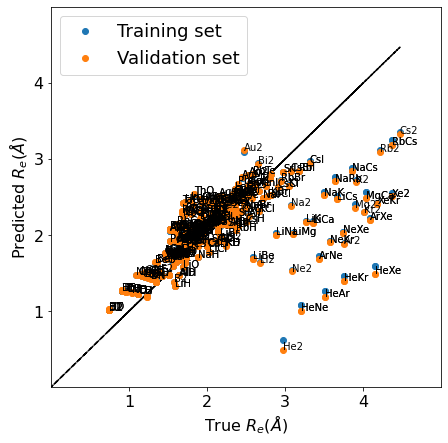

In [12]:
re_train_preds,re_test_preds,out,fig,ax=plot_results(gr,'True $R_e(\AA)$','Predicted $R_e(\AA)$','Re (\AA)',r_y_train_preds,r_y_test_preds);
pyplot.savefig('r_lr_1.svg')
for i in range(len(re_test_preds)):
    if abs(gr['Re (\AA)'].tolist()[i]-re_test_preds[i])<0.1:
        continue
    ax.annotate(gr['Molecule'].tolist()[i], (gr['Re (\AA)'].tolist()[i], re_test_preds[i]))
pyplot.savefig('r_lr_1_annot.svg')

In [14]:
results('$R_e$ LR results with features p1, p2, g1, g2, ln(e1*e2)',gr,'Re (\AA)',re_test_preds,314,MAE,RMSE,R,r"stat_summ.csv")
split_stat = pd.DataFrame(list(zip(Train_MAE,Train_RMSE,Train_R,MAE,RMSE,R)),columns =['Train_MAE','Train_RMSE','Train_R','MAE','RMSE','R'])
split_stat.to_csv('split_stat.csv')
gr['re_test_preds']=re_test_preds
gr['re_train_preds']=re_test_preds
gr.to_csv('r_lr_1_gr_pred.csv')